# The Cropland Data Layer (CDL) and Random Forest

A raster dataset available from the USDA that identifies crops and land uses from satelite imagery.

- 30m resolution
- Entire U.S.
- All states from 2008 till today.

A "census by satelite."

### How do they identify land uses?

An application of __supervised machine learning!__

After extensive data is collected from several satelites (AWiFS and MODIS) and geological survey data (Landsat TM) the task is to use these measurments to do a classification. The goal is to classify a single pixel into one of the categories of land use.

The following slides are from [this presentation](https://www.nass.usda.gov/Research_and_Science/Cropland/Method/cropland.pdf) from the USDA.

<center>
<img src="cdl-inputs.png" width="500">
</center>

__So they have the X, where is the y?__


<center>
<img src="ag-ground.png" width="500">
</center>

The Farm Service Agency provides the "on-the-ground truth" of which pixel is what kind of crop.

<center>
<img src="non-ag-ground.png" width="500">
</center>
The US Geological Service provides the "on-the-ground truth" for non-crop pixels.

### Prediction Works This Way:
<center>
<img src="prediction.png" width="700">
</center>
According to their presentation, they hold out 30% of the sample to do training.

### What algorithm do they use?

From what I can tell, the CDL uses __decision trees__.

How to use decision trees for prediction is a whole class by itself, but let's start with a brief explanation about the  concepts.

### Decision Trees: A Bin Estimator Explanation.

Suppose I have three discrete levels of one variable, altitude, while I will call $X$. The levels are $x_1, x_2, x_3$.

Now suppose I have a variable that represents whether a pixel is a coffee plant or no. Call it $y=\{0,1\}$.


If I were looking at data like this:


|  |     |     |          ||
|:-|:-|:-|:-|:-|
|X   |$x_1$  |$x_2$  |$x_3$  |$x_1$|  
|y   | 0     | 0     | 1     | 0     |

What might we conclude about using $X$ to predict $y$?

Now suppose we have more data:

|  |     |     |          ||||
|:-|:-|:-|:-|:-|:-|:-|
|X   |$x_1$  |$x_2$  |$x_3$  |$x_1$|$x_2$| $x_3$|  
|y   | 0     | 0     | 1     | 0     | 1 | 1|


How has it changed?

It looks like now the relationship is not so clear. Coffee is sometimes grown at $x_2$ and sometimes not...

So to understand it better, I might try including another variable $Z$.

|  |     |     |          ||||
|:-|:-|:-|:-|:-|:-|:-|
| Z  |$z_1$  |$z_1$  |$z_1$  |$z_2$|$z_2$| $z_2$|  
|X   |$x_1$  |$x_2$  |$x_3$  |$x_1$|$x_2$| $x_3$|  
|y   | 0     | 0     | 1     | 0     | 1 | 1|


Now how has our view changed?

So to make a good predictor of $y$, we could essentially just start splitting things into bins.

For example:

$z_1$ or $z_2$?
- if $z_1$, 
    + is $x\neq x_3$? then $y=0$
    + is $x=x_3$? then $y=1$
- if $z_2$
    + is $x=x_1$? then $y=0$
    + is $x \neq x_1$? then $y=1$
        
This would be a perfectly acceptable estimator of $y$, and is in fact a __decision tree estimator__.

#### An example algorithm:
- Make an initial split, which produces "leaves."
- Is the value of the dependent variable all one value?
    - if yes, end that leaf.
    - if no, do another split.
- Continue until a certain condition is met or the algorithm perfectly predicts.

__What may be the problem with an algorithm that perfectly predicts?__

__That algorithm is probably overfitting the data__.

For example, it may be coffee plants in a certain area are grown with specific conditions. The algorithm might mistakenly then identify __anything__ grown in those conditions as a coffee plant. Thus the algorithm "overfits" the data by making its identification too specific to the data it has.

This is why we do K-fold cross validation, for example.

<center>
<img src="decision_tree_diagram.png" width="600">
</center>
    

[From this article](https://towardsdatascience.com/decision-tree-intuition-from-concept-to-application-530744294bb6), which is cited in [this presentation](https://docs.google.com/presentation/d/1AB2Adsf0akogIisth58prYRrLXzBYshBkLYvZUqnlhk/edit#slide=id.g75470aa6df_0_0)

### Decision tree terminology:
- Leaf: the final category after splitting.
- Splitting: subsetting the target variable based on the features.
- Max depth: the maximum depth of the tree.
- Node: the decision node at which the split is being made.

#### How does it know when to split?

Essentially, its looking for an "information gain" from splitting. One metric it can use is __Entropy:__ $ -\sum^N_i p_i log_2(p_i)$ where there are $N$ labels to predict and $p_i$ is the probability of label $i$. 
<center>
<img src="entropy.png" width="400">
</center>

[figure source](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8)

Entropy is highest the more mixed a set of targets is. If the probability were always 1, then the entropy score would be zero (as it would be if the probability were always zero).

Thus if our leaves are more "ordered" after a split, we made an __entropy gain__. An entropy gain is essentially: $Ent(y) - Ent(y|x)$ where $E$ is a measure of entropy.

__The analog for a continuous $y$ would be mean squared error (MSE)__

### Random Forest
Recall that to find information gains the algorithm is just splitting features until it finds something. What if it splits the wrong way? How can we correct this?

Since one decision tree could make errors, often times the predictions of several trees are averaged together to make a __random forest__. Since we are randomly splitting, the trees are arguably __uncorrelated__. It ends up working a lot like a bootstrap estimator.

Also will stop it from __overfitting__ too much.

Other methods for combining trees are __boosting__ and __ensembling__.

An example from [this link](https://blog.hyperiondev.com/index.php/2019/02/18/machine-learning/) where each image contains a number, specifically numbers from street signs. The data set is the [Street View House Numbers dataset](http://ufldl.stanford.edu/housenumbers/) and is managed by Stanford.

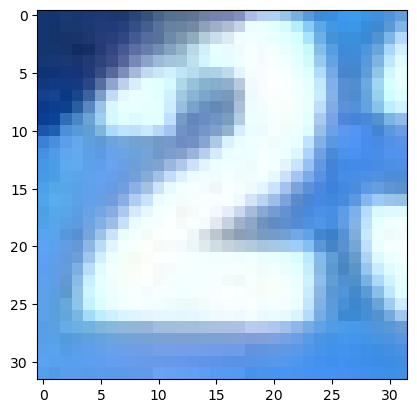

[2]


In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

data_dir="C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/2_Images/"

# load our dataset
train_data = scipy.io.loadmat(data_dir + 'train_32x32.mat')
# extract the images and labels from the dictionary object
X = train_data['X']
y = train_data['y']
# view an image (e.g. 25) and print its corresponding label
img_index = 2
plt.imshow(X[:,:,:,img_index])
plt.show()
print(y[img_index])

In [4]:
X.shape

(32, 32, 3, 73257)

So these are small images (32x32) with RGB chanels. There are 73k of them in this dataset.

This size will not work for the Random Forest algorithm, as we need a 2-dimensional array instead.

In [6]:
X_re = X.reshape(X.shape[0]*X.shape[1]*X.shape[2],X.shape[3]).T
y_re = y.reshape(y.shape[0],)

In [7]:
X_re.shape

(73257, 3072)

__What are the features now?__

Technically every possible pixel of the image (in each band) is its own feature. It does not seem intuitive that this would work...

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10) # Giving it 10 trees, 
                                                   # which is one of the hyperparameters we can use.

Let's now do the split that the CDL uses: 30% test data and 70% training data.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.3, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [10]:
from sklearn.metrics import accuracy_score
preds = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test,preds))

Accuracy: 0.5647010647010647


Not bad! But what about different amounts of trees?

In [11]:
def tree_test(number_of_trees):
    clf = RandomForestClassifier(n_estimators=number_of_trees)
    X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    return accuracy_score(y_test,preds)

In [12]:
tree_grid = np.arange(1,111,10)
vals = [tree_test(x) for x in tree_grid]

### The "Elbow Rule"

Text(0.5, 0, 'Number of Trees')

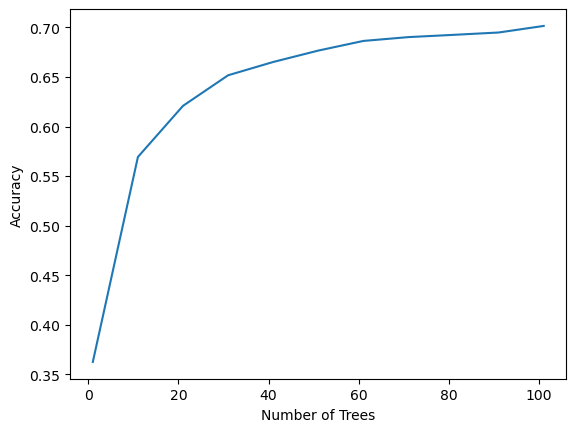

In [13]:
plt.plot(tree_grid,vals)
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")

Which value should we use?

The __"Elbow Rule"__ is an informal heuristic for choosing hyperparameters.

Choose the value at which your marginal rate of improvement starts to approach zero. Usually it doesn't go back down, so just pick the point where it starts to level off.

### What are some ways I can improve the prediction even more?

- Train it using cross-validation
    - In the above example I'm only splitting it once. K-fold cross-validation would split it K times and take the average performance.
- Train different hyperparameters
    - I'm only doing optimization over one dimension, but I could choose more hyper parameters.
- __Boost__ instead of __bagging__
    - Random forest uses bagging, which is aggregating performance over trees in parallel. Boosting does it sequentially, making each new tree use the residuals of the previous tree.

While the algorithm seems naive, as you can see it can be quite powerful. Some advantages of Random Forest:
1. It is __intuitive__, unlike other supervised ML algorithms.
    - The mechanics of how it works can be easily understood.
2. It is __versatile__, in that it can do classification and regression.
    - $y$ can be continuous or discrete.
3. It is __fast__, in that it can train on large datasets with lots of features.
    - Also easy to parallelize.
4. No preprocessing needed (like normalization for example).


Some drawbacks:
1. No model interpretation (like most ML algorithms).
2. Tends to overfit, meaning make sure you tune hyperparameters.
3. Seems to be dumped in favor of neural nets more and more, possibly because:
    - Neural nets can handle more types of data.
    - Neural nets often outperform most algorithms.
    
However, it seems like Random Forests in general need less data than neural networks.